/tmp/ipykernel_1351792/1648722494.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  deflection_MeV[i] = scipy.interpolate.interp1d(mat['deflection_curve_mm'][:, 0],


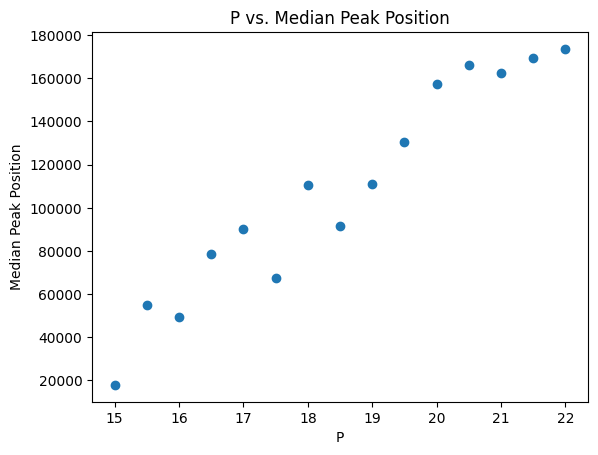

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy

def deflection_calc(hor_image_size, electron_pointing_pixel):
    pixel_in_mm = 0.137
    deflection_MeV = np.zeros(hor_image_size)
    deflection_mm = np.zeros(hor_image_size)
    mat = scipy.io.loadmat('data/Deflection_curve_Mixture_Feb28.mat')
    for i in range(hor_image_size):
        if i <= electron_pointing_pixel:
            deflection_mm[i] = 0
        else:
            deflection_mm[i] = (i - electron_pointing_pixel) * pixel_in_mm
            
    for i in range(electron_pointing_pixel, hor_image_size):
        xq = deflection_mm[i]
        mask = xq > 1
        if mask.any():
            deflection_MeV[i] = scipy.interpolate.interp1d(mat['deflection_curve_mm'][:, 0],
                                                           mat['deflection_curve_MeV'][:, 0],
                                                           kind='linear',
                                                           assume_sorted=False,
                                                           bounds_error=False)(xq[mask]).astype(np.float32)
    return deflection_MeV


def bi_exponential_deflection(x, a1=77.855568601465, b1=0.466485822903793, a2=19.911755340829, b2=0.043573073167125255):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)

def bi_exponential_deflection_dx(x, a1=-36.318518986697, b1=0.466485822903793, a2=-0.86761637235184, b2=0.043573073167125255):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)


def deflection_biexp_calc(hor_image_size, electron_pointing_pixel, pixel_in_mm=0.137):
    linear_space = np.arange(hor_image_size) * pixel_in_mm
    linear_space -= electron_pointing_pixel * pixel_in_mm
    deflection_mm = linear_space.clamp(min=0)
    mask = deflection_mm > 1
    deflection_MeV = np.zeros_like(deflection_mm)

    deflection_MeV_dx = np.zeros_like(deflection_mm)
    deflection_MeV[mask] = bi_exponential_deflection(deflection_mm[mask]).to(np.float32)
    deflection_MeV_dx[mask] = bi_exponential_deflection_dx(deflection_mm[mask]).to(np.float32)
    return deflection_MeV, deflection_MeV_dx


def calc_spec(image, electron_pointing_pixel, deflection_MeV, acquisition_time_ms, image_gain=0, noise=False, deflection_MeV_dx=None):
    image_gain /= 32
    if noise:
        noise_level = np.median(np.array([image[int(image.shape[0]*0.9), int(image.shape[1]*0.05)],
                                          image[int(image.shape[0]*0.9), int(image.shape[1]*0.9)],
                                          image[int(image.shape[0]*0.1), int(image.shape[1]*0.9)]]))
        image[image <= noise_level] = 0
    hor_image_size = image.shape[1]
    horizontal_profile = np.sum(image, axis=0)
    spectrum_in_pixel = np.zeros(hor_image_size)
    spectrum_in_MeV = np.zeros(hor_image_size)

    for j in range(electron_pointing_pixel, hor_image_size):
        spectrum_in_pixel[j] = horizontal_profile[j]
        derivative = deflection_MeV[j-1] - deflection_MeV[j] if deflection_MeV_dx is None else -deflection_MeV_dx[j]
        if derivative != 0:
            spectrum_in_MeV[j] = spectrum_in_pixel[j] / derivative
    spectrum_in_MeV[~np.isfinite(spectrum_in_MeV)] = 0

    acquisition_time_ms = np.array(acquisition_time_ms)
    spectrum_calibrated = (spectrum_in_MeV * 3.706) / (acquisition_time_ms*image_gain) if image_gain else (spectrum_in_MeV * 3.706) / acquisition_time_ms
    return spectrum_calibrated


def find_peak(array):
    peaks = scipy.signal.find_peaks(array, prominence=1000)
    # print(peaks)
    if len(peaks[1]['prominences']) != 0:
        res = array[peaks[0][np.argmax(peaks[1]['prominences'])]]
    else:
        res = 0
    return res


# Read the CSV file
csv_path = 'test/params.csv'
df = pd.read_csv(csv_path)

# Dictionary to store median peak positions for each folder
median_peaks = {}
folder_acq_times = df.set_index('path')['ms'].to_dict()

# Process images in each folder
root_folder = 'test'
deflection_MeV = deflection_calc(512, 62)
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
        peak_positions = []
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if os.path.isfile(image_path) and image_path.endswith(('.png', '.jpg', '.jpeg')):
                acq_time = folder_acq_times.get(folder_path)
                img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                array = calc_spec(img, 62, deflection_MeV, acq_time, 0, False, None)
                peak_position = find_peak(array)
                peak_positions.append(peak_position)
        if peak_positions:
            median_peaks[folder_path] = np.median(peak_positions)

# Convert folder names to P values
# p_values = [df[df['path'] == folder_name]['P'].iloc[0] for folder_name in median_peaks.keys()]
p_values = []
for folder_path in median_peaks.keys():
    matching_rows = df[df['path'] == folder_path]
    if not matching_rows.empty:
        p_values.append(matching_rows['P'].iloc[0])
    else:
        print(f"No matching entry in CSV for folder: {folder_path}")
median_positions = list(median_peaks.values())

# Plotting
plt.scatter(p_values, median_positions)
plt.xlabel('P')
plt.ylabel('Median Peak Position')
plt.title('P vs. Median Peak Position')
plt.show()